<a href="https://colab.research.google.com/github/dlinero/AI-canopy-height-estimation/blob/main/Canopy_height_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [ ]:
!pip install rasterio
!pip install torchgeo
!pip install torchinfo

import os
# Using rasters
import rasterio
from google.colab import drive

os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # this helps error tracing when data/ models are on the GPU
os.environ['TORCH_USE_CUDA_DSA'] = '1' # this helps error tracing when data/ models are on the GPU

# Data management
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
import tempfile
import pandas as pd

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch add-ons
import torchmetrics
from torchinfo import summary # useful for summarizing models
import segmentation_models_pytorch as smp

# Visualization
import matplotlib.pyplot as plt



In [ ]:
# Mount google drive
drive.mount('/content/drive')
tiles_path = "/content/drive/MyDrive/AI for earth observation/Final project/tropical_tiles_raw"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set seed
seed = 14
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# See how many cpus we have available
num_cpus = os.cpu_count()
print(num_cpus)

12


## Define functions

In [ ]:
# plot a histogram of all the bands of an image sample
def plotImgBands(img):
    colors = ['black', 'blue', 'purple', 'blue']
    bands = ['S1_VV_dB', 'S1_VH_dB', 'Elevation', 'Slope']
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axes = axes.flatten() # Flatten the 2x3 grid of axes to a 1D array

    for i in range(img.shape[0]):
        window = "Radar" if i < 2 else "Topography"
        axes[i].hist(img[i].flatten(), bins=30, color=colors[i])
        axes[i].set_title(f'{window} - {bands[i]} Band Histogram')
        axes[i].set_xlabel('Pixel Value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout() # Adjust layout to prevent overlapping titles
    plt.show()


In [ ]:
# Compute mean and standard deviation for each band across the whole dataset
def computeBandStats(dataset, n_chnls = 4):
    mean = torch.zeros(n_chnls) # create empty 1D tensor to hold the per-band means across all images.
    var = torch.zeros(n_chnls)  # create empty 1D tensor to hold the per-band variances across all images.

    for i in range(len(dataset)):
        img = dataset[i]["image"] # get image
        mean += torch.nanmean(img, dim=(1,2))

    # Calculate mean
    mean /= len(dataset)

    for i in range(len(dataset)):
        img = dataset[i]["image"] # get image
        var += torch.nanmean((img - mean.unsqueeze(1).unsqueeze(2))**2, dim=(1, 2))

    # Calculate standard deviation
    std_dev = torch.sqrt(var / len(dataset))

    return mean, std_dev

In [ ]:
# Function to run train and validation
def train_and_val(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  val_dataloader: torch.utils.data.DataLoader,
                  loss_fun: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  num_epochs: int,
                  device: torch.device):
  # move model to gpu
  model.to(device)

  # Create lists to store training and validation losses
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    # TRAIN ---
    model.train()
    train_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
      # Send data to GPU
      X = batch["image"].to(device)
      y = batch["response"].to(device)
      # 1. Forward pass
      y_pred = model(X)
      # 2. Calculate loss
      loss = loss_fun(y_pred, y)
      # 3. Optimizer zero gradient
      optimizer.zero_grad()
      # 4. Loss backpropagation
      loss.backward()
      # 5. Optimizer step
      optimizer.step()
      # 6. Accumulate loss
      train_loss += loss.item()

    # average train loss across all train batches
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # VALIDATION ---
    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for batch in val_dataloader:
          # Send data to GPU
          X, y = batch["image"].to(device), batch["response"].to(device)
          # Forward pass (aka model prediction)
          pred = model(X)
          # Calculate loss
          loss = loss_fun(pred, y)
          # Accumulate loss
          val_loss += loss.item()
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:03d} | Train loss: {train_loss:.5f} | Validation loss: {val_loss:.5f}")

  return train_losses, val_losses

In [ ]:
# Function for testing
def test_step(dataloader, model, loss_fn, device=device):
    total_loss = 0.0
    y_true, y_pred = [], []

    model.to(device)
    model.eval()  # eval mode

    with torch.inference_mode():
        for data in dataloader:
            X = data["image"].to(device)
            y = data["response"].to(device)

            # forward
            pred = model(X)

            # loss for this batch
            batch_loss = loss_fn(pred, y).item()
            total_loss += batch_loss

            # store for RMSE
            y_true.append(y.cpu().numpy().ravel())
            y_pred.append(pred.cpu().numpy().ravel())

    # average loss over batches
    avg_loss = total_loss / len(dataloader)

    # concat all pixels/values and compute RMSE
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

    print(f"Test loss: {avg_loss:.5f} | RMSE: {rmse:.5f}")

    return avg_loss, rmse

In [ ]:
# To create final comparison plot
def summarize_last_epoch(results_dict):
    summary = {}

    for model_name, metrics in results_dict.items():
        train_loss_list = metrics["train_loss"]
        val_loss_list   = metrics["val_loss"]

        train_loss_last = train_loss_list[-1]
        val_loss_last   = val_loss_list[-1]

        summary[model_name] = {
            "train_loss_last": train_loss_last,
            "val_loss_last":   val_loss_last,
            "train_rmse_last": np.sqrt(train_loss_last),
            "val_rmse_last":   np.sqrt(val_loss_last),
        }

    return pd.DataFrame(summary).T

In [ ]:
# Plot results of the final selected model
def predict_test_set(model, dataloader, device):
    model.eval()
    model.to(device)

    all_y_true = []
    all_y_pred = []

    with torch.inference_mode():
        for batch in dataloader:
            X = batch["image"].to(device)        # (B, 4, H, W)
            y_true = batch["response"].to(device)  # (B, 1, H, W)

            y_pred = model(X)                   # (B, 1, H, W)

            all_y_true.append(y_true.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

    # Whole test set (N, 1, H, W)
    all_y_true = np.concatenate(all_y_true, axis=0)
    all_y_pred = np.concatenate(all_y_pred, axis=0)

    return all_y_true, all_y_pred

def visualize_test_tile(test_dataset, y_true_all, y_pred_all,
                        idx=0, band_idx=0, cmap="viridis"):

    sample = test_dataset[idx]
    X = sample["image"].numpy()             # (4, H, W)

    y_true = y_true_all[idx, 0, :, :]       # (H, W)
    y_pred = y_pred_all[idx, 0, :, :]       # (H, W)
    band = X[band_idx, :, :]                # Input predictor band

    error = y_pred - y_true

    vmin = min(y_true.min(), y_pred.min())
    vmax = max(y_true.max(), y_pred.max())

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))

    # Input band
    im0 = axs[0].imshow(band, cmap=cmap, interpolation="nearest")
    axs[0].set_title(f"Input band {band_idx + 1}")
    plt.colorbar(im0, ax=axs[0], fraction=0.04, pad=0.04)

    # True canopy height
    im1 = axs[1].imshow(y_true, cmap=cmap, interpolation="nearest",
                        vmin=vmin, vmax=vmax)
    axs[1].set_title("True canopy height")
    plt.colorbar(im1, ax=axs[1], fraction=0.04, pad=0.04)

    # Predicted canopy height
    im2 = axs[2].imshow(y_pred, cmap=cmap, interpolation="nearest",
                        vmin=vmin, vmax=vmax)
    axs[2].set_title("Predicted canopy height")
    plt.colorbar(im2, ax=axs[2], fraction=0.04, pad=0.04)

    # Error map
    im3 = axs[3].imshow(error, cmap="coolwarm", interpolation="nearest")
    axs[3].set_title("Error (pred - true)")
    plt.colorbar(im3, ax=axs[3], fraction=0.04, pad=0.04)

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


## Define classes

In [ ]:
# Normalizing the images
class NormalizeImage(object):
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean.tolist(), std.tolist())

    def __call__(self, sample):
        sample['image'] = self.normalize(sample['image'])
        return sample

In [ ]:
# Create torch dataset
class TilesDataset(Dataset):
    def __init__(self, tile_list, transforms=None):
        self.tiles = tile_list
        self.transforms = transforms

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        sample = self.tiles[idx]

        sample = {
            "image": sample["image"],
            "response": sample["response"],
            "path": sample["path"]
        }

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

In [ ]:
# data augmentation
class RandomFlipRotate:
    def __call__(self, sample):
        image = sample["image"]
        response = sample["response"]

        # Horizontal flip
        if torch.rand(1) < 0.5:
            image = torch.flip(image, dims=[2])
            response = torch.flip(response, dims=[2])

        # Vertical flip
        if torch.rand(1) < 0.5:
            image = torch.flip(image, dims=[1])
            response = torch.flip(response, dims=[1])

        # Random 0, 90, 180, 270 degree rotation
        k = torch.randint(0, 4, (1,)).item()
        if k > 0:
            image = torch.rot90(image, k, dims=[1, 2])
            response = torch.rot90(response, k, dims=[1, 2])

        sample["image"] = image
        sample["response"] = response
        return sample

class AddRadarNoise(object):
    def __init__(self, train_std, frac=0.05):
        # frac is the proportion of the channel std to use as noise
        self.vv_noise_std = frac * train_std[0].item()  # VV
        self.vh_noise_std = frac * train_std[1].item()  # VH

    def __call__(self, sample):
        image = sample["image"]
        response = sample["response"]

        # Apply noise randomly
        if torch.rand(1) < 0.5:
            noise_vv = torch.randn_like(image[0:1]) * self.vv_noise_std
            noise_vh = torch.randn_like(image[1:2]) * self.vh_noise_std
            image[0:1] = image[0:1] + noise_vv
            image[1:2] = image[1:2] + noise_vh

        # update dict
        sample["image"] = image
        sample["response"] = response
        return sample

## Load and prepare data

In [ ]:
tile_files = sorted([
    os.path.join(tiles_path, f) for f in os.listdir(tiles_path)
])

print("Number of tiles: ", len(tile_files))

# Check raster characteristics
with rasterio.open(tile_files[0]) as sample:
    arr = sample.read()  # (bands, height, width)
    print("Shape:", arr.shape)
    print("CRS:", sample.crs)
    print("Resolution:", sample.res)

Number of tiles:  999
Shape: (5, 64, 64)
CRS: EPSG:32725
Resolution: (10.02975891691392, 10.028023510185449)


In [ ]:
# Create an empty dataset to hold all tiles in a dictionary form
all_tiles = []
for path in tile_files:
    with rasterio.open(path) as tile:
        arr = tile.read().astype(np.float32)  # (5, 64, 64)

    # 4 first bands are predictors
    image = arr[0:4, :,:]
    # Last band is canopy height
    response = arr[4:5, :, :].astype(np.float32) / 100.0

    # Create tensors
    image_t = torch.from_numpy(image) # (4,64,64)
    response_t = torch.from_numpy(response) # (1,64,64)


    sample = {
        'image': image_t,
        'response': response_t,
        'path': path
    }

    all_tiles.append(sample)

Number of tiles loaded:  999
<class 'list'>
<class 'dict'>
torch.Size([4, 64, 64])
torch.Size([1, 64, 64])
torch.float32
torch.float32
/content/drive/MyDrive/AI for earth observation/Final project/tropical_tiles_raw/tile_148.tif


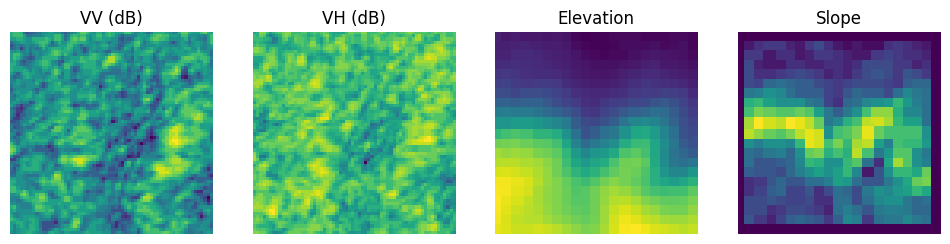

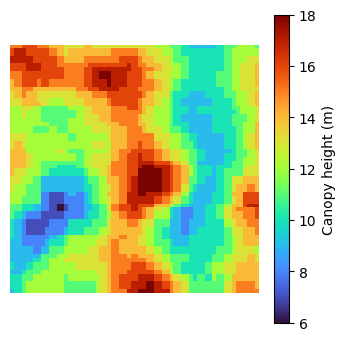

In [ ]:
# Inspect results
print("Number of tiles loaded: ", len(all_tiles))
print(type(all_tiles))
idx = 55
sample = all_tiles[idx]
print(type(sample))
print(sample["image"].shape)
print(sample["response"].shape)
print(sample["image"].dtype)
print(sample["response"].dtype)
print(sample['path'])
# Visualize one example
img_np = sample['image'].numpy()
response_np = sample['response'].numpy().squeeze()

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
band_names = ["VV (dB)", "VH (dB)", "Elevation", "Slope"]

for i in range(4):
    axs[i].imshow(img_np[i], cmap="viridis")
    axs[i].set_title(band_names[i])
    axs[i].axis("off")

plt.show()

plt.figure(figsize=(4,4))
plt.imshow(response_np, cmap="turbo")
plt.colorbar(label="Canopy height (m)")
plt.axis("off")
plt.show()


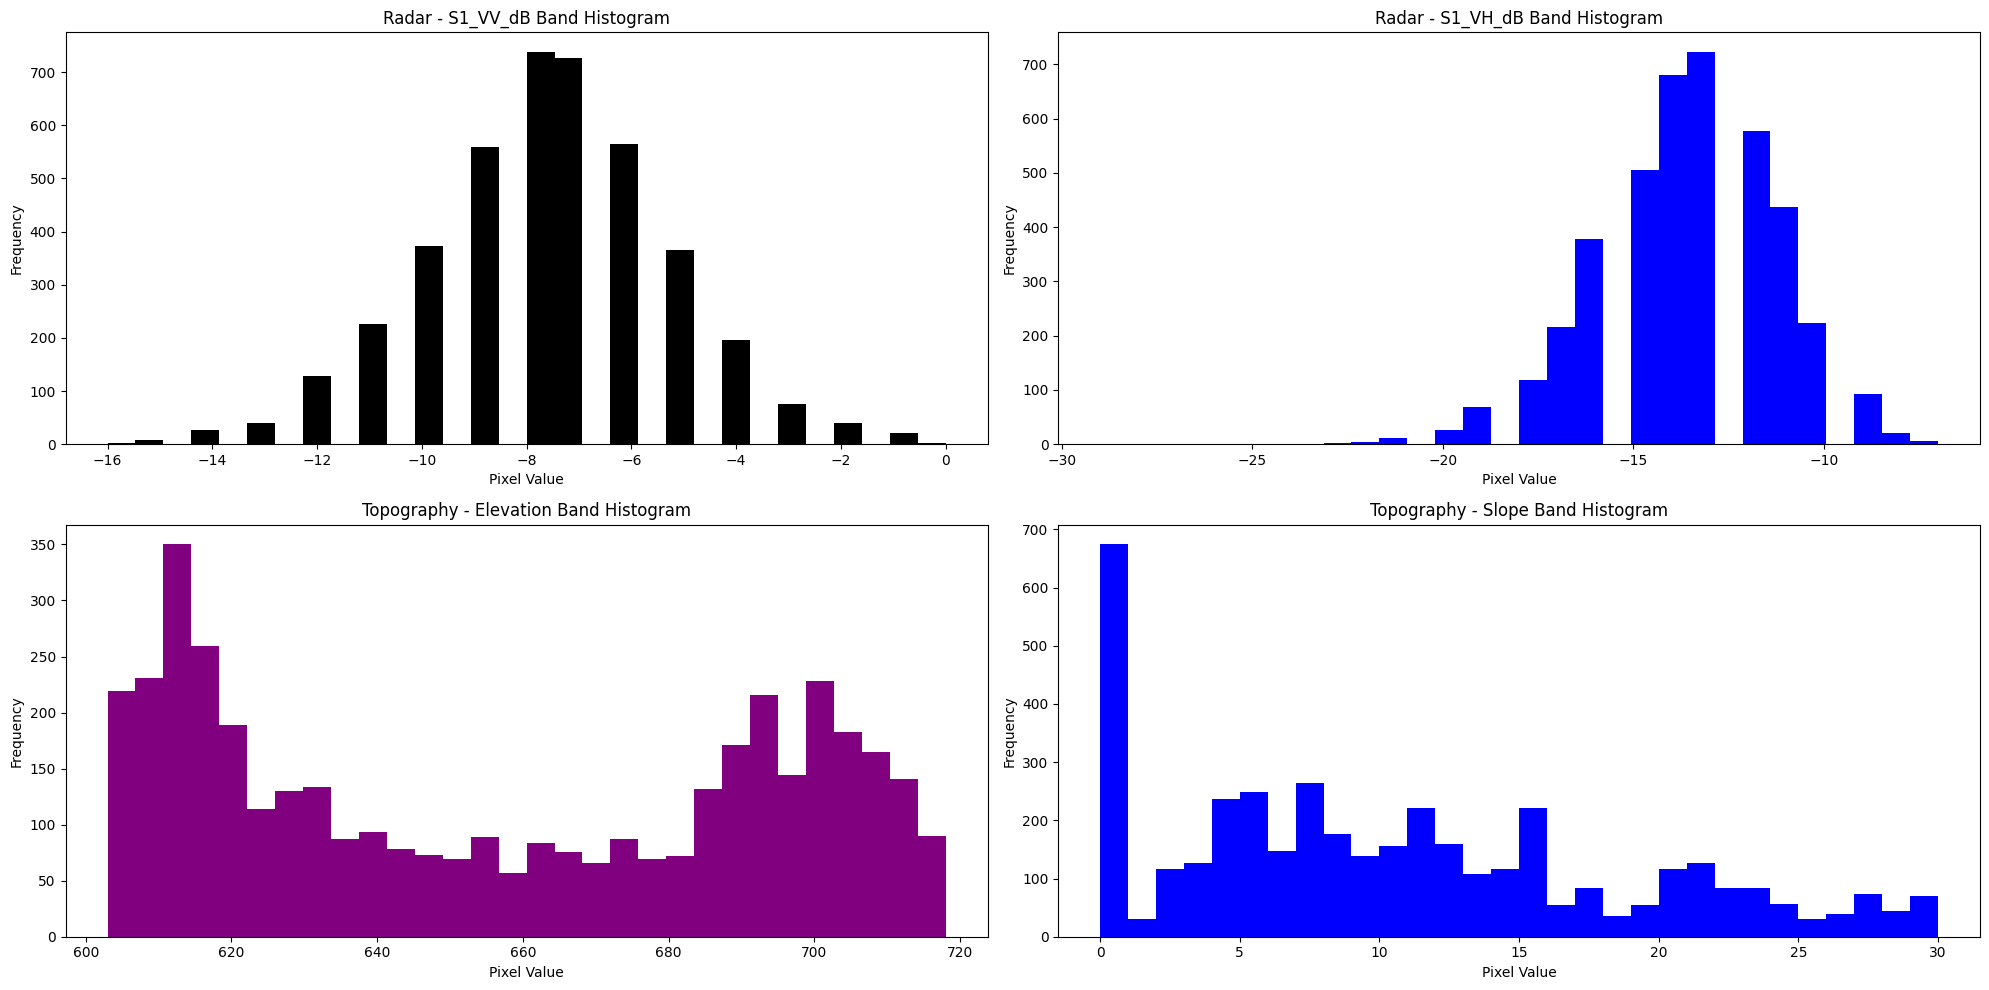

In [ ]:
# Plot band histograms for a sample
plotImgBands(sample["image"])

In [ ]:
# Split data (not randomly because tile generation was already random)
N = len(all_tiles)

n_train, n_val, n_test = round(0.70 * N), round(0.15 * N), round(0.15 * N)
train_tiles, val_tiles, test_tiles = all_tiles[:n_train], all_tiles[n_train:n_train+n_val], all_tiles[n_train+n_val:]

print("Train:", len(train_tiles))
print("Val:", len(val_tiles))
print("Test:", len(test_tiles))


Train: 699
Val: 150
Test: 150


## Normalize the data

In [ ]:
# Calculate mean and standard deviation per band for the training split
train_mean, train_std = computeBandStats(train_tiles,n_chnls = 4)
print(f"Mean: {train_mean}")
print(f"St Dev: {train_std}")

# Set up transform
transform = transforms.Compose([NormalizeImage(train_mean, train_std)])

# Apply transform
train_dataset = TilesDataset(train_tiles, transforms=transform)
val_dataset   = TilesDataset(val_tiles,   transforms=transform)
test_dataset  = TilesDataset(test_tiles,  transforms=transform)

Mean: tensor([ -8.2002, -14.7590, 470.3000,   7.7904])
St Dev: tensor([  3.7336,   4.1530, 636.8130,   9.4790])


In [ ]:
# Check results
imgs_norm = []
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    imgs_norm.append(sample["image"])

imgs_norm = torch.stack(imgs_norm)

print("Mean per band AFTER norm:", imgs_norm.mean(dim=(0, 2, 3)))
print("Std  per band AFTER norm:", imgs_norm.std(dim=(0, 2, 3)))


Mean per band AFTER norm: tensor([-6.0388e-07, -2.8282e-06,  1.8683e-07, -4.3007e-07])
Std  per band AFTER norm: tensor([1.0000, 1.0000, 1.0000, 1.0000])


## DataLoader

In [ ]:
train_dl = DataLoader(train_dataset, batch_size = 10, shuffle = True, num_workers=num_cpus)
val_dl = DataLoader(val_dataset, batch_size = 10, shuffle = False, num_workers=num_cpus)
test_dl = DataLoader(test_dataset, batch_size = 10, shuffle = False, num_workers=num_cpus)

# Before data augmentation

## Basic UNet

In [ ]:
# Double convolution block
class ConvBlock(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(out_c)
    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(out_c)
    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x

class UNetSmall(nn.Module):
    def __init__(self, in_c=4, out_c=1):
        super().__init__()

        # Encoder
        self.down1 = ConvBlock(in_c, 32)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(128, 256)

        # Decoder
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(64, 32)

        # Final regression layer
        self.outputs = nn.Conv2d(32, out_c, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.pool1(x1)
        x3 = self.down2(x2)
        x4 = self.pool2(x3)
        x5 = self.down3(x4)
        x6 = self.pool3(x5)

        # Bottleneck
        x_bn = self.bottleneck(x6)

        # Decoder
        x = self.up3(x_bn)
        x = torch.cat([x, x5], dim=1)
        x = self.dec3(x)
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        out = self.outputs(x)
        return out

In [ ]:
# Instantiate  model
basic_unet = UNetSmall(in_c=4, out_c=1)
# Check UNet architecture
summary(basic_unet, input_size=(1, 4, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
UNetSmall                                [1, 1, 64, 64]            --
├─ConvBlock: 1-1                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 32, 64, 64]           1,184
│    └─BatchNorm2d: 2-2                  [1, 32, 64, 64]           64
│    └─ReLU: 2-3                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 32, 64, 64]           9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 64, 64]           64
│    └─ReLU: 2-6                         [1, 32, 64, 64]           --
├─MaxPool2d: 1-2                         [1, 32, 32, 32]           --
├─ConvBlock: 1-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-7                       [1, 64, 32, 32]           18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 32, 32]           128
│    └─ReLU: 2-9                         [1, 64, 32, 32]           --
│   

In [ ]:
# Set loss function
loss_fn = nn.MSELoss()  # mean squared error
optimizer = torch.optim.Adam(basic_unet.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 100

# Train model
train_losses_basic, val_losses_basic = train_and_val(
    model = basic_unet,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 540.58499 | Validation loss: 519.94500
Epoch 002 | Train loss: 496.79735 | Validation loss: 477.79841
Epoch 003 | Train loss: 445.89915 | Validation loss: 332.64426
Epoch 004 | Train loss: 375.61466 | Validation loss: 311.14842
Epoch 005 | Train loss: 294.42792 | Validation loss: 250.79381
Epoch 006 | Train loss: 232.71476 | Validation loss: 164.50802
Epoch 007 | Train loss: 185.00866 | Validation loss: 139.05263
Epoch 008 | Train loss: 146.76578 | Validation loss: 96.64592
Epoch 009 | Train loss: 117.01191 | Validation loss: 104.92777
Epoch 010 | Train loss: 107.32892 | Validation loss: 154.20580
Epoch 011 | Train loss: 113.02706 | Validation loss: 104.54581
Epoch 012 | Train loss: 99.33279 | Validation loss: 106.87700
Epoch 013 | Train loss: 96.56897 | Validation loss: 88.43512
Epoch 014 | Train loss: 98.51208 | Validation loss: 95.38458
Epoch 015 | Train loss: 96.31501 | Validation loss: 84.29578
Epoch 016 | Train loss: 96.21903 | Validation loss: 101.28206
E

In [ ]:
# Compute RMSE: On average, how far are predictions from the true value?
rmse = (val_losses_basic[num_epochs-1] ** 0.5)
print(f"Validation MSE: {val_losses_basic[num_epochs-1]:.2f} | Validation RMSE: {rmse:.2f}")

Validation MSE: 94.84 | Validation RMSE: 9.74


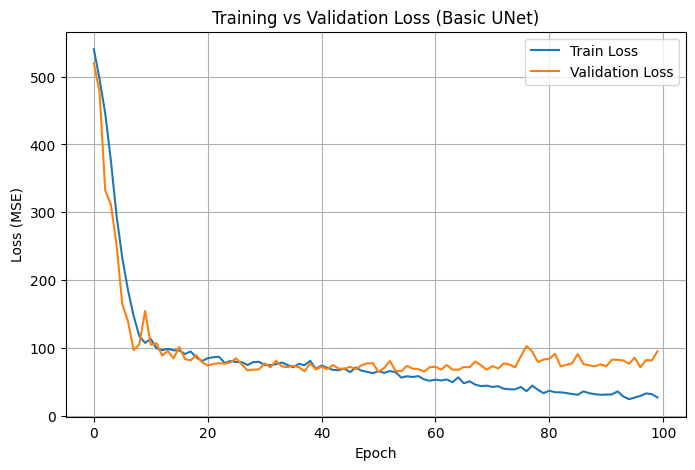

In [ ]:
# Plot train vs val loss per epoch
plt.figure(figsize=(8,5))
plt.plot(train_losses_basic, label='Train Loss')
plt.plot(val_losses_basic, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss (Basic UNet)')
plt.legend()
plt.grid(True)
plt.show()

##UNet with a RestNet18 backbone

In [ ]:
# Load model
unet_resnet18 = smp.Unet(
    encoder_name= 'resnet18', encoder_depth=4, encoder_weights= None,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32],
    decoder_use_norm="batchnorm"
)

# Check arquitecture
summary(model = unet_resnet18, input_size=(10,4,64,64), col_names=["input_size", "output_size", "num_params"],
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape               Output Shape              Param #
Unet (Unet)                                        [10, 4, 64, 64]           [10, 1, 64, 64]           --
├─ResNetEncoder (encoder)                          [10, 4, 64, 64]           [10, 4, 64, 64]           8,393,728
│    └─Conv2d (conv1)                              [10, 4, 64, 64]           [10, 64, 32, 32]          12,544
│    └─BatchNorm2d (bn1)                           [10, 64, 32, 32]          [10, 64, 32, 32]          128
│    └─ReLU (relu)                                 [10, 64, 32, 32]          [10, 64, 32, 32]          --
│    └─MaxPool2d (maxpool)                         [10, 64, 32, 32]          [10, 64, 16, 16]          --
│    └─Sequential (layer1)                         [10, 64, 16, 16]          [10, 64, 16, 16]          --
│    │    └─BasicBlock (0)                         [10, 64, 16, 16]          [10, 64, 16, 16]          73,984
│    │    └─BasicBlock (1

In [ ]:
# Set optimizer
optimizer_resnet18 = torch.optim.Adam(unet_resnet18.parameters(), lr=0.001, weight_decay=1e-4)

train_losses_resnet18, val_losses_resnet18 = train_and_val(
    model = unet_resnet18,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer_resnet18,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 407.44145 | Validation loss: 358.94299
Epoch 002 | Train loss: 183.75429 | Validation loss: 123.35237
Epoch 003 | Train loss: 116.38730 | Validation loss: 126.40590
Epoch 004 | Train loss: 112.48833 | Validation loss: 111.46422
Epoch 005 | Train loss: 111.97346 | Validation loss: 114.58967
Epoch 006 | Train loss: 107.77531 | Validation loss: 97.90648
Epoch 007 | Train loss: 107.20831 | Validation loss: 98.05243
Epoch 008 | Train loss: 103.18959 | Validation loss: 95.23051
Epoch 009 | Train loss: 98.68410 | Validation loss: 100.93908
Epoch 010 | Train loss: 94.47267 | Validation loss: 84.12875
Epoch 011 | Train loss: 99.94867 | Validation loss: 93.41223
Epoch 012 | Train loss: 93.61553 | Validation loss: 89.77809
Epoch 013 | Train loss: 93.22994 | Validation loss: 85.92939
Epoch 014 | Train loss: 86.85255 | Validation loss: 99.41108
Epoch 015 | Train loss: 85.86571 | Validation loss: 75.74725
Epoch 016 | Train loss: 85.76775 | Validation loss: 93.45423
Epoch 017 

In [ ]:
unet_resnet18_weights = smp.Unet(
    encoder_name= 'resnet18', encoder_weights= "imagenet", encoder_depth= 4,
    in_channels=4, classes=1, decoder_channels=[256,128,64,32],
    decoder_use_norm="batchnorm"
)

optimizer_resnet18_weights = torch.optim.Adam(unet_resnet18_weights.parameters(), lr=0.001, weight_decay=1e-4)

train_losses_resnet18_weights, val_losses_resnet18_weights = train_and_val(
    model = unet_resnet18_weights,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer_resnet18_weights,
    num_epochs=num_epochs,
    device=device
)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 001 | Train loss: 382.50410 | Validation loss: 191.42833
Epoch 002 | Train loss: 146.90913 | Validation loss: 115.08224
Epoch 003 | Train loss: 105.43718 | Validation loss: 95.09883
Epoch 004 | Train loss: 105.47590 | Validation loss: 122.04039
Epoch 005 | Train loss: 105.11182 | Validation loss: 87.40771
Epoch 006 | Train loss: 96.51751 | Validation loss: 92.50888
Epoch 007 | Train loss: 95.83048 | Validation loss: 85.39830
Epoch 008 | Train loss: 90.96953 | Validation loss: 85.43907
Epoch 009 | Train loss: 96.27771 | Validation loss: 86.63935
Epoch 010 | Train loss: 88.26099 | Validation loss: 77.19366
Epoch 011 | Train loss: 89.06869 | Validation loss: 93.55695
Epoch 012 | Train loss: 91.72506 | Validation loss: 74.70008
Epoch 013 | Train loss: 93.96862 | Validation loss: 75.41532
Epoch 014 | Train loss: 84.30269 | Validation loss: 73.51182
Epoch 015 | Train loss: 80.27479 | Validation loss: 92.66547
Epoch 016 | Train loss: 89.98644 | Validation loss: 74.23916
Epoch 017 | Trai

## EfficientNet

In [ ]:
# Load models
efficientnet = smp.Unet(
    encoder_name= 'efficientnet-b1', encoder_depth=4, encoder_weights= None,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

efficientnet_weights = smp.Unet(
    encoder_name= 'efficientnet-b1', encoder_weights= "imagenet", encoder_depth=4,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

# Check architectures
summary(model = efficientnet, input_size=(10,4,64,64), col_names=["input_size", "output_size", "num_params"],
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape               Output Shape              Param #
Unet (Unet)                                                       [10, 4, 64, 64]           [10, 1, 64, 64]           --
├─EfficientNetEncoder (encoder)                                   [10, 4, 64, 64]           [10, 4, 64, 64]           412,160
│    └─Conv2dStaticSamePadding (_conv_stem)                       [10, 4, 64, 64]           [10, 32, 32, 32]          1,152
│    │    └─ZeroPad2d (static_padding)                            [10, 4, 64, 64]           [10, 4, 65, 65]           --
│    └─BatchNorm2d (_bn0)                                         [10, 32, 32, 32]          [10, 32, 32, 32]          64
│    └─SiLU (_swish)                                              [10, 32, 32, 32]          [10, 32, 32, 32]          --
│    └─ModuleList (_blocks)                                       --                        --                        --
│    │    └─MBConvB

In [ ]:
optimizer_efficientnet = torch.optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_efficientnet_weights = torch.optim.Adam(efficientnet_weights.parameters(), lr=0.001, weight_decay=1e-4)

train_losses_efficientnet, val_losses_efficientnet = train_and_val(
    model = efficientnet,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer_efficientnet,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 387.82767 | Validation loss: 183.57415
Epoch 002 | Train loss: 159.22983 | Validation loss: 145.94582
Epoch 003 | Train loss: 117.03406 | Validation loss: 142.31678
Epoch 004 | Train loss: 109.03332 | Validation loss: 122.01756
Epoch 005 | Train loss: 105.17785 | Validation loss: 110.39828
Epoch 006 | Train loss: 106.50318 | Validation loss: 441.39727
Epoch 007 | Train loss: 100.00518 | Validation loss: 122.75640
Epoch 008 | Train loss: 94.93494 | Validation loss: 97.03074
Epoch 009 | Train loss: 96.39838 | Validation loss: 194.29703
Epoch 010 | Train loss: 92.04970 | Validation loss: 88.42957
Epoch 011 | Train loss: 84.96822 | Validation loss: 81.83065
Epoch 012 | Train loss: 77.57809 | Validation loss: 152.93164
Epoch 013 | Train loss: 75.42913 | Validation loss: 84.91436
Epoch 014 | Train loss: 73.94765 | Validation loss: 77.90868
Epoch 015 | Train loss: 77.16488 | Validation loss: 76.72649
Epoch 016 | Train loss: 61.70948 | Validation loss: 94.61634
Epoch 01

In [ ]:
train_losses_efficientnet_weights, val_losses_efficientnet_weights = train_and_val(
    model = efficientnet_weights,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer_efficientnet_weights,
    num_epochs=num_epochs,
    device=device
)


Epoch 001 | Train loss: 354.64657 | Validation loss: 156.43226
Epoch 002 | Train loss: 132.43341 | Validation loss: 107.27446
Epoch 003 | Train loss: 88.31758 | Validation loss: 83.49684
Epoch 004 | Train loss: 71.94021 | Validation loss: 101.79914
Epoch 005 | Train loss: 67.63203 | Validation loss: 86.17485
Epoch 006 | Train loss: 53.86765 | Validation loss: 69.25282
Epoch 007 | Train loss: 50.67868 | Validation loss: 79.20054
Epoch 008 | Train loss: 51.07823 | Validation loss: 65.50580
Epoch 009 | Train loss: 46.62779 | Validation loss: 70.28020
Epoch 010 | Train loss: 43.59307 | Validation loss: 71.58692
Epoch 011 | Train loss: 44.15494 | Validation loss: 77.68839
Epoch 012 | Train loss: 38.23802 | Validation loss: 72.88188
Epoch 013 | Train loss: 40.69030 | Validation loss: 66.04527
Epoch 014 | Train loss: 37.05720 | Validation loss: 85.32810
Epoch 015 | Train loss: 39.47504 | Validation loss: 72.53229
Epoch 016 | Train loss: 33.56871 | Validation loss: 68.14024
Epoch 017 | Train l

## MobileNetV2

In [ ]:
# Load models
mobilenet = smp.Unet(
    encoder_name= 'mobilenet_v2', encoder_depth=4, encoder_weights= None,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

mobilenet_weights = smp.Unet(
    encoder_name= 'mobilenet_v2', encoder_weights= "imagenet", encoder_depth=4,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

# Check arquitectures
summary(model = mobilenet, input_size=(10,4,64,64), col_names=["input_size", "output_size", "num_params"],
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape               Output Shape              Param #
Unet (Unet)                                        [10, 4, 64, 64]           [10, 1, 64, 64]           --
├─MobileNetV2Encoder (encoder)                     [10, 4, 64, 64]           [10, 4, 64, 64]           --
│    └─Sequential (features)                       --                        --                        --
│    │    └─Conv2dNormActivation (0)               [10, 4, 64, 64]           [10, 32, 32, 32]          1,216
│    │    └─InvertedResidual (1)                   [10, 32, 32, 32]          [10, 16, 32, 32]          896
│    │    └─InvertedResidual (2)                   [10, 16, 32, 32]          [10, 24, 16, 16]          5,136
│    │    └─InvertedResidual (3)                   [10, 24, 16, 16]          [10, 24, 16, 16]          8,832
│    │    └─InvertedResidual (4)                   [10, 24, 16, 16]          [10, 32, 8, 8]            10,000
│    │    └─InvertedResidua

In [ ]:
optimizer_mobilenet = torch.optim.Adam(mobilenet.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_mobilenet_weights = torch.optim.Adam(mobilenet_weights.parameters(), lr=0.001, weight_decay=1e-4)

train_losses_mobilenet, val_losses_mobilenet = train_and_val(
    model = mobilenet,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer_mobilenet,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 352.09169 | Validation loss: 190.13056
Epoch 002 | Train loss: 143.62576 | Validation loss: 112.75918
Epoch 003 | Train loss: 111.48899 | Validation loss: 103.59357
Epoch 004 | Train loss: 103.97643 | Validation loss: 107.10846
Epoch 005 | Train loss: 102.52487 | Validation loss: 103.69348
Epoch 006 | Train loss: 95.12073 | Validation loss: 86.52857
Epoch 007 | Train loss: 88.68485 | Validation loss: 92.01999
Epoch 008 | Train loss: 82.56954 | Validation loss: 82.76181
Epoch 009 | Train loss: 77.92843 | Validation loss: 94.96016
Epoch 010 | Train loss: 76.51605 | Validation loss: 96.76444
Epoch 011 | Train loss: 70.10950 | Validation loss: 84.29344
Epoch 012 | Train loss: 71.20864 | Validation loss: 82.26050
Epoch 013 | Train loss: 63.43378 | Validation loss: 85.47173
Epoch 014 | Train loss: 63.69608 | Validation loss: 124.50708
Epoch 015 | Train loss: 67.38065 | Validation loss: 103.34268
Epoch 016 | Train loss: 63.69202 | Validation loss: 84.01475
Epoch 017 | 

In [ ]:
train_losses_mobilenet_weights, val_losses_mobilenet_weights = train_and_val(
    model = mobilenet_weights,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer_mobilenet_weights,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 335.83728 | Validation loss: 176.07942
Epoch 002 | Train loss: 129.48943 | Validation loss: 174.11052
Epoch 003 | Train loss: 86.00038 | Validation loss: 78.95932
Epoch 004 | Train loss: 72.52494 | Validation loss: 83.53021
Epoch 005 | Train loss: 64.06313 | Validation loss: 91.67789
Epoch 006 | Train loss: 57.20741 | Validation loss: 77.97837
Epoch 007 | Train loss: 58.10136 | Validation loss: 82.70221
Epoch 008 | Train loss: 54.02524 | Validation loss: 77.74025
Epoch 009 | Train loss: 52.90063 | Validation loss: 74.58502
Epoch 010 | Train loss: 50.99381 | Validation loss: 79.42604
Epoch 011 | Train loss: 45.43336 | Validation loss: 73.43679
Epoch 012 | Train loss: 43.67606 | Validation loss: 73.00945
Epoch 013 | Train loss: 38.06255 | Validation loss: 82.67027
Epoch 014 | Train loss: 40.63970 | Validation loss: 82.17509
Epoch 015 | Train loss: 36.43559 | Validation loss: 86.26760
Epoch 016 | Train loss: 36.97445 | Validation loss: 75.84226
Epoch 017 | Train lo

## Mix Vision Transformer (MiT)

In [ ]:
# Load models
mit = smp.Unet(
    encoder_name= 'mit_b0', encoder_depth=4, encoder_weights= None,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

mit_weights = smp.Unet(
    encoder_name= 'mit_b0', encoder_weights= "imagenet", encoder_depth=4,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

# Check arquitectures
summary(model = mit, input_size=(10,4,64,64), col_names=["input_size", "output_size", "num_params"],
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape               Output Shape              Param #
Unet (Unet)                                        [10, 4, 64, 64]           [10, 1, 64, 64]           --
├─MixVisionTransformerEncoder (encoder)            [10, 4, 64, 64]           [10, 4, 64, 64]           1,969,920
│    └─OverlapPatchEmbed (patch_embed1)            [10, 4, 64, 64]           [10, 32, 16, 16]          --
│    │    └─Conv2d (proj)                          [10, 4, 64, 64]           [10, 32, 16, 16]          6,304
│    │    └─LayerNorm (norm)                       [10, 32, 16, 16]          [10, 32, 16, 16]          64
│    └─Sequential (block1)                         [10, 32, 16, 16]          [10, 32, 16, 16]          --
│    │    └─Block (0)                              [10, 32, 16, 16]          [10, 32, 16, 16]          79,616
│    │    └─Block (1)                              [10, 32, 16, 16]          [10, 32, 16, 16]          79,616
│    └─LayerNorm (norm1

In [ ]:
optimizer_mit = torch.optim.Adam(mit.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_mit_weights = torch.optim.Adam(mit_weights.parameters(), lr=0.001, weight_decay=1e-4)

train_losses_mit, val_losses_mit = train_and_val(
    model = mit,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer_mit,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 353.25229 | Validation loss: 194.28764
Epoch 002 | Train loss: 163.43784 | Validation loss: 131.50724
Epoch 003 | Train loss: 115.73986 | Validation loss: 113.69634
Epoch 004 | Train loss: 114.58280 | Validation loss: 119.46274
Epoch 005 | Train loss: 108.37104 | Validation loss: 108.79732
Epoch 006 | Train loss: 105.50102 | Validation loss: 114.16354
Epoch 007 | Train loss: 117.90825 | Validation loss: 122.78537
Epoch 008 | Train loss: 117.38630 | Validation loss: 128.48610
Epoch 009 | Train loss: 115.32793 | Validation loss: 110.81524
Epoch 010 | Train loss: 109.84470 | Validation loss: 108.29035
Epoch 011 | Train loss: 105.64370 | Validation loss: 110.90379
Epoch 012 | Train loss: 101.44436 | Validation loss: 101.38402
Epoch 013 | Train loss: 99.49575 | Validation loss: 101.67667
Epoch 014 | Train loss: 95.03003 | Validation loss: 94.74417
Epoch 015 | Train loss: 96.89172 | Validation loss: 99.91691
Epoch 016 | Train loss: 130.03184 | Validation loss: 121.648

In [ ]:
train_losses_mit_weights, val_losses_mit_weights = train_and_val(
    model = mit_weights,
    train_dataloader= train_dl,
    val_dataloader=val_dl,
    loss_fun=loss_fn,
    optimizer=optimizer_mit_weights,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 371.30257 | Validation loss: 237.05371
Epoch 002 | Train loss: 149.93486 | Validation loss: 114.14751
Epoch 003 | Train loss: 106.74939 | Validation loss: 104.87885
Epoch 004 | Train loss: 101.68064 | Validation loss: 105.72744
Epoch 005 | Train loss: 95.81447 | Validation loss: 85.87369
Epoch 006 | Train loss: 90.18881 | Validation loss: 113.10118
Epoch 007 | Train loss: 91.85759 | Validation loss: 102.04655
Epoch 008 | Train loss: 84.70373 | Validation loss: 120.77617
Epoch 009 | Train loss: 80.16371 | Validation loss: 87.84304
Epoch 010 | Train loss: 75.92295 | Validation loss: 88.38262
Epoch 011 | Train loss: 71.37571 | Validation loss: 86.86973
Epoch 012 | Train loss: 69.06758 | Validation loss: 108.86932
Epoch 013 | Train loss: 65.04764 | Validation loss: 89.18086
Epoch 014 | Train loss: 59.00268 | Validation loss: 89.22814
Epoch 015 | Train loss: 57.69813 | Validation loss: 85.27303
Epoch 016 | Train loss: 51.67118 | Validation loss: 85.36687
Epoch 017 | 

## Model comparison, pre-augmentation

In [ ]:
# Join all results
results_pre = {
    "UNetSmall": {
        "train_loss": train_losses_basic,
        "val_loss":   val_losses_basic,
    },
    "UNet_ResNet18 without weights": {
        "train_loss": train_losses_resnet18,
        "val_loss":   val_losses_resnet18,
    },
    "UNet_ResNet18 with weights": {
        "train_loss": train_losses_resnet18_weights,
        "val_loss":   val_losses_resnet18_weights,
    },
    "UNet_EfficientNet without weights": {
        "train_loss": train_losses_efficientnet,
        "val_loss":   val_losses_efficientnet,
    },
    "UNet_EfficientNet with weights": {
        "train_loss": train_losses_efficientnet_weights,
        "val_loss":   val_losses_efficientnet_weights,
    },
    "UNet_MobileNetV2 without weights": {
        "train_loss": train_losses_mobilenet,
        "val_loss":   val_losses_mobilenet,
    },
    "UNet_MobileNetV2 with weights": {
        "train_loss": train_losses_mobilenet_weights,
        "val_loss":   val_losses_mobilenet_weights,
    },
    "Mix Vision Transformer without weights": {
        "train_loss": train_losses_mit,
        "val_loss":   val_losses_mit,
    },
    "Mix Vision Transformer with weights": {
        "train_loss": train_losses_mit_weights,
        "val_loss":   val_losses_mit_weights,
    }
}

In [ ]:
# Add train_rmse to each model in the dict
for model_name, metrics in results_pre.items():
    train_loss = metrics["train_loss"]
    results_pre[model_name]["train_rmse"] = [np.sqrt(l) for l in train_loss]

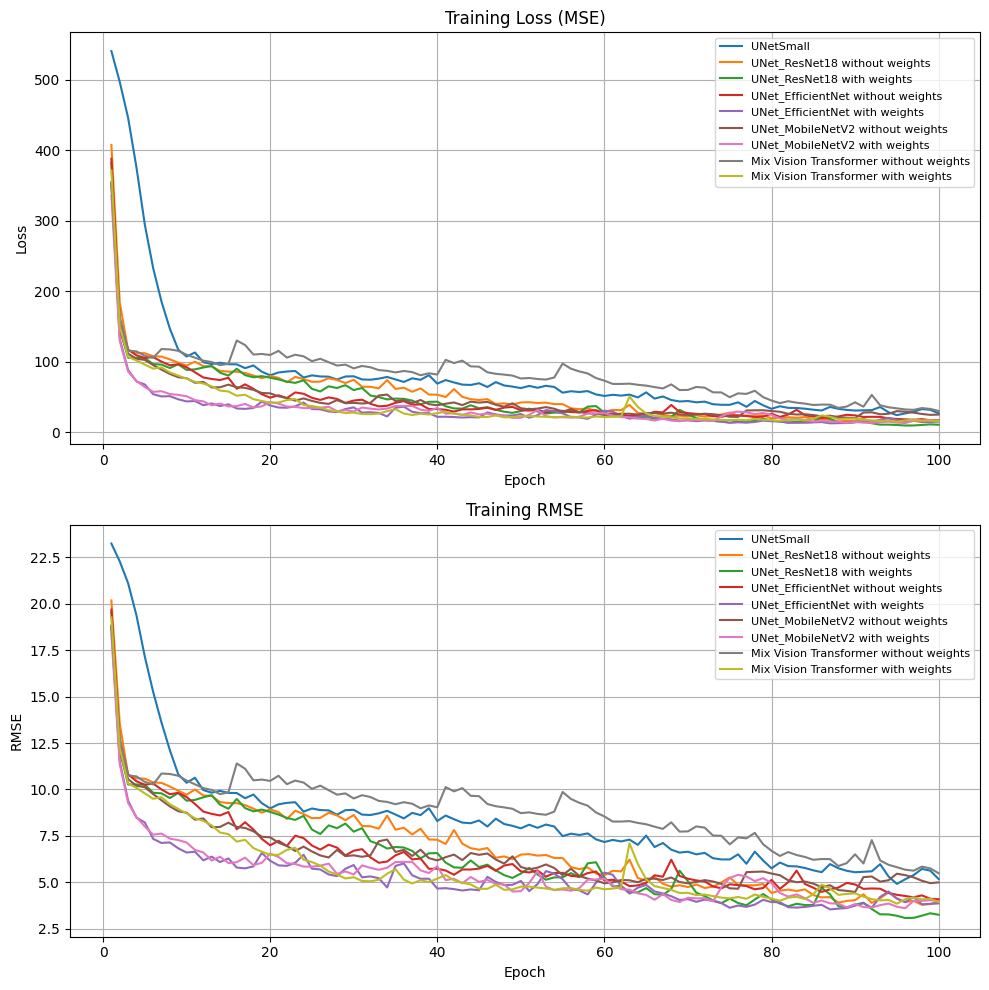

In [ ]:
def plot_train_metrics(results_dict):
    epochs = range(1, len(next(iter(results_dict.values()))["train_loss"]) + 1)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # --- TRAIN LOSS ---
    ax = axes[0]
    for model_name, metrics in results_dict.items():
        ax.plot(epochs, metrics["train_loss"], label=model_name)
    ax.set_title("Training Loss (MSE)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend(fontsize=8)

    # --- TRAIN RMSE ---
    ax = axes[1]
    for model_name, metrics in results_dict.items():
        ax.plot(epochs, metrics["train_rmse"], label=model_name)
    ax.set_title("Training RMSE")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("RMSE")
    ax.grid(True)
    ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

plot_train_metrics(results_pre)

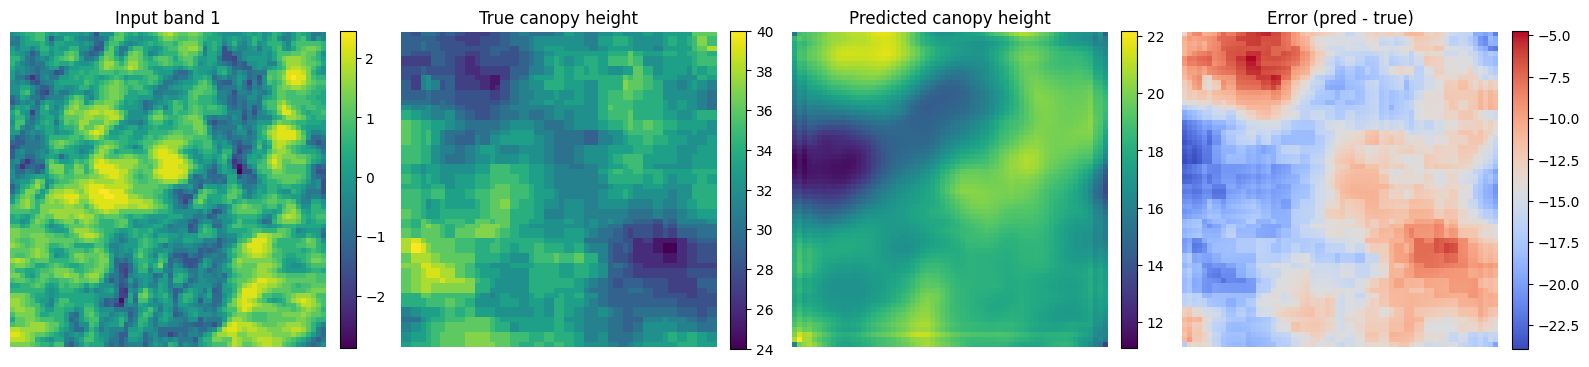

In [ ]:
def visualize_prediction(model, dataloader, device, idx_in_batch=0):
    model.eval()

    # Get one batch
    batch = next(iter(dataloader))
    X = batch["image"].to(device)       # (B, 4, H, W)
    y_true = batch["response"].to(device)  # (B, 1, H, W)

    with torch.inference_mode():
        y_pred = model(X)               # (B, 1, H, W)

    # Move to CPU and select one example
    X_np      = X[idx_in_batch].cpu().numpy()        # (4, H, W)
    y_true_np = y_true[idx_in_batch, 0].cpu().numpy() # (H, W)
    y_pred_np = y_pred[idx_in_batch, 0].cpu().numpy() # (H, W)

    # Optional: pick one input band to show (e.g., band 0 = VV)
    band0 = X_np[0, :, :]

    # Error map
    error = y_pred_np - y_true_np

    # ---- PLOT ----
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    im0 = axs[0].imshow(band0, cmap="viridis")
    axs[0].set_title("Input band 1")
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(y_true_np, cmap="viridis")
    axs[1].set_title("True canopy height")
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(y_pred_np, cmap="viridis")
    axs[2].set_title("Predicted canopy height")
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    im3 = axs[3].imshow(error, cmap="coolwarm")
    axs[3].set_title("Error (pred - true)")
    plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_prediction(efficientnet_weights, val_dl, device, idx_in_batch=0)


# After data augmentation

I will try the following approaches:


*   Horizontal and vertical flip
*   90° rotations
*   Small random noise to radar data





In [ ]:
# Apply transform
train_dataset = TilesDataset(train_tiles, transforms=transform)
val_dataset   = TilesDataset(val_tiles,   transforms=transform)
test_dataset  = TilesDataset(test_tiles,  transforms=transform)


# Apply approaches
train_transform = transforms.Compose([
    RandomFlipRotate(),
    AddRadarNoise(train_std, frac=0.05),
    NormalizeImage(train_mean, train_std)
])

eval_transform = transforms.Compose([
    NormalizeImage(train_mean, train_std)
])

train_augmented = TilesDataset(train_tiles, transforms=train_transform)
val_augmented   = TilesDataset(val_tiles,   transforms=eval_transform)
test_augmented  = TilesDataset(test_tiles,  transforms=eval_transform)

# Create dataloaders
train_dl_aug = DataLoader(train_augmented, batch_size = 10, shuffle = True, num_workers=num_cpus)
val_dl_aug = DataLoader(val_augmented, batch_size = 10, shuffle = False, num_workers=num_cpus)
test_dl_aug = DataLoader(test_augmented, batch_size = 10, shuffle = False, num_workers=num_cpus)

In [ ]:
# Data augmentation here is on-the-fly: each epoch the same sample can be flipped/rotated/noised differently, but the dataset length doesn’t increase
print("Train samples:", len(train_augmented))

Train samples: 699


## Basic UNet

In [ ]:
# Instantiate  model
basic_unet_aug = UNetSmall(in_c=4, out_c=1)
optimizer = torch.optim.Adam(basic_unet_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_basic_aug, val_losses_basic_aug = train_and_val(
    model = basic_unet_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 544.64945 | Validation loss: 518.53869
Epoch 002 | Train loss: 487.81784 | Validation loss: 456.03881
Epoch 003 | Train loss: 430.85141 | Validation loss: 374.56161
Epoch 004 | Train loss: 367.98029 | Validation loss: 327.69326
Epoch 005 | Train loss: 298.33748 | Validation loss: 261.35915
Epoch 006 | Train loss: 237.79252 | Validation loss: 171.79614
Epoch 007 | Train loss: 191.42572 | Validation loss: 146.98275
Epoch 008 | Train loss: 149.61169 | Validation loss: 98.42376
Epoch 009 | Train loss: 119.61924 | Validation loss: 119.12125
Epoch 010 | Train loss: 114.16608 | Validation loss: 89.57096
Epoch 011 | Train loss: 105.77536 | Validation loss: 107.88470
Epoch 012 | Train loss: 105.18533 | Validation loss: 85.66412
Epoch 013 | Train loss: 99.35086 | Validation loss: 106.77056
Epoch 014 | Train loss: 97.31667 | Validation loss: 81.29832
Epoch 015 | Train loss: 94.65062 | Validation loss: 83.68428
Epoch 016 | Train loss: 87.63789 | Validation loss: 79.07040
Ep

##UNet with a RestNet18 backbone

In [ ]:
# Load model
unet_resnet18_aug = smp.Unet(
    encoder_name= 'resnet18', encoder_depth=4, encoder_weights= None,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32],
    decoder_use_norm="batchnorm"
)

optimizer_resnet18 = torch.optim.Adam(unet_resnet18_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_resnet18_aug, val_losses_resnet18_aug = train_and_val(
    model = unet_resnet18_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer_resnet18,
    num_epochs=num_epochs,
    device=device
)


Epoch 001 | Train loss: 403.40651 | Validation loss: 323.56247
Epoch 002 | Train loss: 165.29063 | Validation loss: 119.74904
Epoch 003 | Train loss: 116.84496 | Validation loss: 106.60927
Epoch 004 | Train loss: 115.22976 | Validation loss: 113.15368
Epoch 005 | Train loss: 113.78640 | Validation loss: 119.05748
Epoch 006 | Train loss: 110.05363 | Validation loss: 106.33710
Epoch 007 | Train loss: 104.40060 | Validation loss: 96.76203
Epoch 008 | Train loss: 98.97871 | Validation loss: 102.81118
Epoch 009 | Train loss: 106.54988 | Validation loss: 104.40880
Epoch 010 | Train loss: 100.67541 | Validation loss: 107.32469
Epoch 011 | Train loss: 100.35258 | Validation loss: 91.08356
Epoch 012 | Train loss: 93.69895 | Validation loss: 79.76549
Epoch 013 | Train loss: 97.04123 | Validation loss: 78.33082
Epoch 014 | Train loss: 86.87842 | Validation loss: 75.43453
Epoch 015 | Train loss: 87.63759 | Validation loss: 89.75127
Epoch 016 | Train loss: 89.85954 | Validation loss: 73.59645
Epoch

In [ ]:
# Load model
unet_resnet18_weights_aug = smp.Unet(
    encoder_name= 'resnet18', encoder_weights= "imagenet", encoder_depth= 4,
    in_channels=4, classes=1, decoder_channels=[256,128,64,32],
    decoder_use_norm="batchnorm"
)

optimizer_resnet18_weights = torch.optim.Adam(unet_resnet18_weights_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_resnet18_weights_aug, val_losses_resnet18_weights_aug = train_and_val(
    model = unet_resnet18_weights_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer_resnet18_weights,
    num_epochs=num_epochs,
    device=device
)


Epoch 001 | Train loss: 377.84669 | Validation loss: 181.49282
Epoch 002 | Train loss: 152.68991 | Validation loss: 100.08267
Epoch 003 | Train loss: 112.78966 | Validation loss: 94.90113
Epoch 004 | Train loss: 100.96061 | Validation loss: 96.57908
Epoch 005 | Train loss: 96.30346 | Validation loss: 81.48454
Epoch 006 | Train loss: 90.68038 | Validation loss: 95.72766
Epoch 007 | Train loss: 92.28898 | Validation loss: 89.98174
Epoch 008 | Train loss: 97.15821 | Validation loss: 78.34333
Epoch 009 | Train loss: 92.28358 | Validation loss: 77.87019
Epoch 010 | Train loss: 85.94602 | Validation loss: 82.35656
Epoch 011 | Train loss: 93.12174 | Validation loss: 70.01813
Epoch 012 | Train loss: 87.47432 | Validation loss: 130.94687
Epoch 013 | Train loss: 83.19866 | Validation loss: 89.85470
Epoch 014 | Train loss: 88.88779 | Validation loss: 77.62747
Epoch 015 | Train loss: 87.74586 | Validation loss: 75.34219
Epoch 016 | Train loss: 87.13331 | Validation loss: 81.03022
Epoch 017 | Train

## EfficientNet

In [ ]:
# Load model
efficientnet_aug = smp.Unet(
    encoder_name= 'efficientnet-b1', encoder_depth=4, encoder_weights= None,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

optimizer_efficientnet = torch.optim.Adam(efficientnet_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_efficientnet_aug, val_losses_efficientnet_aug = train_and_val(
    model = efficientnet_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer_efficientnet,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 413.46127 | Validation loss: 166.15268
Epoch 002 | Train loss: 182.07416 | Validation loss: 162.57558
Epoch 003 | Train loss: 116.10844 | Validation loss: 137.74551
Epoch 004 | Train loss: 109.07665 | Validation loss: 145.34887
Epoch 005 | Train loss: 108.70411 | Validation loss: 120.41612
Epoch 006 | Train loss: 107.69114 | Validation loss: 107.65749
Epoch 007 | Train loss: 104.24866 | Validation loss: 95.73404
Epoch 008 | Train loss: 102.39838 | Validation loss: 149.97810
Epoch 009 | Train loss: 94.29007 | Validation loss: 119.69639
Epoch 010 | Train loss: 98.21079 | Validation loss: 101.63435
Epoch 011 | Train loss: 98.06045 | Validation loss: 89.30056
Epoch 012 | Train loss: 95.16512 | Validation loss: 94.92486
Epoch 013 | Train loss: 89.53290 | Validation loss: 99.20325
Epoch 014 | Train loss: 91.11259 | Validation loss: 82.48424
Epoch 015 | Train loss: 92.65954 | Validation loss: 81.18122
Epoch 016 | Train loss: 82.06815 | Validation loss: 88.53558
Epoch 0

In [ ]:
# Load model
efficientnet_weights_aug = smp.Unet(
    encoder_name= 'efficientnet-b1', encoder_weights= "imagenet", encoder_depth=4,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)
optimizer_efficientnet_weights = torch.optim.Adam(efficientnet_weights_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_efficientnet_weights_aug, val_losses_efficientnet_weights_aug = train_and_val(
    model = efficientnet_weights_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer_efficientnet_weights,
    num_epochs=num_epochs,
    device=device
)

Epoch 001 | Train loss: 384.65552 | Validation loss: 195.76714
Epoch 002 | Train loss: 148.09846 | Validation loss: 90.09494
Epoch 003 | Train loss: 98.38716 | Validation loss: 122.56527
Epoch 004 | Train loss: 86.14300 | Validation loss: 95.14137
Epoch 005 | Train loss: 94.43261 | Validation loss: 71.75058
Epoch 006 | Train loss: 85.18559 | Validation loss: 72.14848
Epoch 007 | Train loss: 74.51884 | Validation loss: 74.44134
Epoch 008 | Train loss: 82.84405 | Validation loss: 114.95510
Epoch 009 | Train loss: 72.82866 | Validation loss: 74.53435
Epoch 010 | Train loss: 72.04918 | Validation loss: 80.58434
Epoch 011 | Train loss: 68.03478 | Validation loss: 73.44746
Epoch 012 | Train loss: 72.35363 | Validation loss: 69.28164
Epoch 013 | Train loss: 62.39005 | Validation loss: 78.68010
Epoch 014 | Train loss: 62.69383 | Validation loss: 79.51357
Epoch 015 | Train loss: 66.81559 | Validation loss: 69.94885
Epoch 016 | Train loss: 62.72560 | Validation loss: 68.86586
Epoch 017 | Train l

## MobileNetV2

In [ ]:
# Load model
mobilenet_aug = smp.Unet(
    encoder_name= 'mobilenet_v2', encoder_depth=4, encoder_weights= None,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

optimizer_mobilenet = torch.optim.Adam(mobilenet_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_mobilenet_aug, val_losses_mobilenet_aug = train_and_val(
    model = mobilenet_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer_mobilenet,
    num_epochs=num_epochs,
    device=device
)


Epoch 001 | Train loss: 395.17559 | Validation loss: 223.73384
Epoch 002 | Train loss: 168.92708 | Validation loss: 121.90368
Epoch 003 | Train loss: 110.25098 | Validation loss: 101.30512
Epoch 004 | Train loss: 115.36671 | Validation loss: 132.97536
Epoch 005 | Train loss: 111.31878 | Validation loss: 103.63168
Epoch 006 | Train loss: 105.21646 | Validation loss: 93.10986
Epoch 007 | Train loss: 101.40109 | Validation loss: 93.69807
Epoch 008 | Train loss: 100.85808 | Validation loss: 100.83180
Epoch 009 | Train loss: 96.98541 | Validation loss: 93.47390
Epoch 010 | Train loss: 100.80252 | Validation loss: 101.24848
Epoch 011 | Train loss: 92.97204 | Validation loss: 109.41660
Epoch 012 | Train loss: 90.88020 | Validation loss: 84.20735
Epoch 013 | Train loss: 89.48754 | Validation loss: 80.51557
Epoch 014 | Train loss: 87.39814 | Validation loss: 85.87984
Epoch 015 | Train loss: 90.64352 | Validation loss: 85.90739
Epoch 016 | Train loss: 86.07219 | Validation loss: 76.90489
Epoch 0

In [ ]:
# Load model
mobilenet_weights_aug = smp.Unet(
    encoder_name= 'mobilenet_v2', encoder_weights= "imagenet", encoder_depth=4,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

optimizer_mobilenet_weights = torch.optim.Adam(mobilenet_weights_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_mobilenet_weights_aug, val_losses_mobilenet_weights_aug = train_and_val(
    model = mobilenet_weights_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer_mobilenet_weights,
    num_epochs=num_epochs,
    device=device
)


Epoch 001 | Train loss: 402.83091 | Validation loss: 243.03902
Epoch 002 | Train loss: 172.49533 | Validation loss: 99.23650
Epoch 003 | Train loss: 96.23185 | Validation loss: 90.56761
Epoch 004 | Train loss: 88.82809 | Validation loss: 82.95590
Epoch 005 | Train loss: 84.10881 | Validation loss: 84.00633
Epoch 006 | Train loss: 89.44923 | Validation loss: 83.48542
Epoch 007 | Train loss: 81.82195 | Validation loss: 79.42638
Epoch 008 | Train loss: 77.89987 | Validation loss: 74.04715
Epoch 009 | Train loss: 77.20937 | Validation loss: 87.69111
Epoch 010 | Train loss: 76.26138 | Validation loss: 85.81508
Epoch 011 | Train loss: 78.63428 | Validation loss: 79.03531
Epoch 012 | Train loss: 73.98015 | Validation loss: 72.94389
Epoch 013 | Train loss: 75.43371 | Validation loss: 66.00651
Epoch 014 | Train loss: 67.35265 | Validation loss: 68.68031
Epoch 015 | Train loss: 75.31918 | Validation loss: 69.73016
Epoch 016 | Train loss: 66.91438 | Validation loss: 67.81312
Epoch 017 | Train los

## Mix Vision Transformer (MiT)

In [ ]:
# Load model
mit_aug = smp.Unet(
    encoder_name= 'mit_b0', encoder_depth=4, encoder_weights= None,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

optimizer_mit = torch.optim.Adam(mit_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_mit_aug, val_losses_mit_aug = train_and_val(
    model = mit_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer_mit,
    num_epochs=num_epochs,
    device=device
)


Epoch 001 | Train loss: 375.16147 | Validation loss: 230.21048
Epoch 002 | Train loss: 163.07945 | Validation loss: 134.89387
Epoch 003 | Train loss: 114.89138 | Validation loss: 111.26024
Epoch 004 | Train loss: 110.00128 | Validation loss: 123.42632
Epoch 005 | Train loss: 114.13365 | Validation loss: 111.61282
Epoch 006 | Train loss: 105.41581 | Validation loss: 112.49156
Epoch 007 | Train loss: 101.30944 | Validation loss: 106.09173
Epoch 008 | Train loss: 108.05422 | Validation loss: 115.48622
Epoch 009 | Train loss: 100.52806 | Validation loss: 101.87687
Epoch 010 | Train loss: 101.62461 | Validation loss: 113.04978
Epoch 011 | Train loss: 103.09673 | Validation loss: 107.22262
Epoch 012 | Train loss: 98.81143 | Validation loss: 104.55555
Epoch 013 | Train loss: 97.68811 | Validation loss: 107.61909
Epoch 014 | Train loss: 98.46936 | Validation loss: 107.16605
Epoch 015 | Train loss: 102.28195 | Validation loss: 103.61579
Epoch 016 | Train loss: 101.11418 | Validation loss: 108.4

In [ ]:
# Load model
mit_weights_aug = smp.Unet(
    encoder_name= 'mit_b0', encoder_weights= "imagenet", encoder_depth=4,
    in_channels=4, classes=1, decoder_channels=[256, 128, 64, 32], decoder_use_norm="batchnorm"
)

optimizer_mit_weights = torch.optim.Adam(mit_weights_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses_mit_weights_aug, val_losses_mit_weights_aug = train_and_val(
    model = mit_weights_aug,
    train_dataloader= train_dl_aug,
    val_dataloader=val_dl_aug,
    loss_fun=loss_fn,
    optimizer=optimizer_mit_weights,
    num_epochs=num_epochs,
    device=device
)



Epoch 001 | Train loss: 369.54559 | Validation loss: 221.82193
Epoch 002 | Train loss: 144.66577 | Validation loss: 123.65344
Epoch 003 | Train loss: 101.86037 | Validation loss: 90.02952
Epoch 004 | Train loss: 103.87403 | Validation loss: 95.38419
Epoch 005 | Train loss: 92.59652 | Validation loss: 92.71693
Epoch 006 | Train loss: 93.35505 | Validation loss: 97.61461
Epoch 007 | Train loss: 86.21114 | Validation loss: 84.43028
Epoch 008 | Train loss: 90.13068 | Validation loss: 120.80644
Epoch 009 | Train loss: 85.11434 | Validation loss: 90.44917
Epoch 010 | Train loss: 86.07535 | Validation loss: 90.99070
Epoch 011 | Train loss: 78.40594 | Validation loss: 90.27879
Epoch 012 | Train loss: 109.53711 | Validation loss: 102.12769
Epoch 013 | Train loss: 94.96052 | Validation loss: 96.27948
Epoch 014 | Train loss: 86.58709 | Validation loss: 81.01816
Epoch 015 | Train loss: 77.29495 | Validation loss: 80.60780
Epoch 016 | Train loss: 76.25348 | Validation loss: 74.31895
Epoch 017 | Tra

## Model comparison, post-augmentation

In [ ]:
# Join all results
results_aug = {
    "UNetSmall": {
        "train_loss": train_losses_basic_aug,
        "val_loss":   val_losses_basic_aug,
    },
    "UNet_ResNet18 without weights": {
        "train_loss": train_losses_resnet18_aug,
        "val_loss":   val_losses_resnet18_aug,
    },
    "UNet_ResNet18 with weights": {
        "train_loss": train_losses_resnet18_weights_aug,
        "val_loss":   val_losses_resnet18_weights_aug,
    },
    "UNet_EfficientNet without weights": {
        "train_loss": train_losses_efficientnet_aug,
        "val_loss":   val_losses_efficientnet_aug,
    },
    "UNet_EfficientNet with weights": {
        "train_loss": train_losses_efficientnet_weights_aug,
        "val_loss":   val_losses_efficientnet_weights_aug,
    },
    "UNet_MobileNetV2 without weights": {
        "train_loss": train_losses_mobilenet_aug,
        "val_loss":   val_losses_mobilenet_aug,
    },
    "UNet_MobileNetV2 with weights": {
        "train_loss": train_losses_mobilenet_weights_aug,
        "val_loss":   val_losses_mobilenet_weights_aug,
    },
    "Mix Vision Transformer without weights": {
        "train_loss": train_losses_mit_aug,
        "val_loss":   val_losses_mit_aug,
    },
    "Mix Vision Transformer with weights": {
        "train_loss": train_losses_mit_weights_aug,
        "val_loss":   val_losses_mit_weights_aug,
    }
}

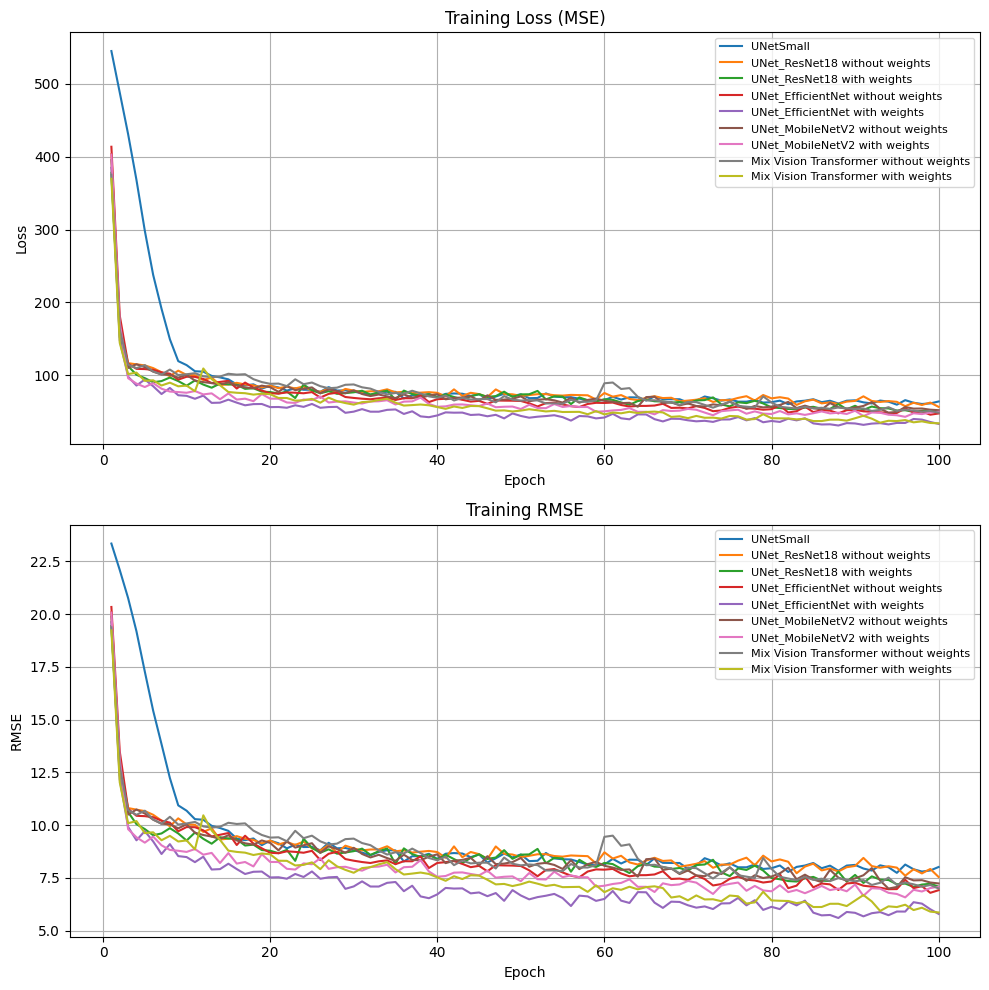

In [ ]:
# Add train_rmse to each model in the dict
for model_name, metrics in results_aug.items():
    train_loss = metrics["train_loss"]
    results_aug[model_name]["train_rmse"] = [np.sqrt(l) for l in train_loss]

plot_train_metrics(results_aug)

# Testing

In [ ]:
models = {
    "Basic unet - no aug": basic_unet,
    "Resnet18 - no weights - no agu": unet_resnet18,
    "Resnet18 - weights - no agu": unet_resnet18_weights,
    "Efficientnet - no weights - no agu": efficientnet,
    "Efficientnet - weights - no agu": efficientnet_weights,
    "Mobilenet - no weights - no agu": mobilenet,
    "Mobilenet - weights - no agu": mobilenet_weights,
    "Mit - no weights - no agu": mit,
    "Mit - weights - no agu": mit_weights,
    "Basic unet - agu": basic_unet_aug,
    "Resnet18 - no weights - agu": unet_resnet18_aug,
    "Resnet18 - weights - agu": unet_resnet18_weights_aug,
    "Efficientnet - no weights - agu": efficientnet_aug,
    "Efficientnet - weights - agu": efficientnet_weights_aug,
    "Mobilenet - no weights - agu": mobilenet_aug,
    "Mobilenet - weights - agu": mobilenet_weights_aug,
    "Mit - no weights - agu": mit_aug,
    "Mit - weights - agu": mit_weights_aug,

}

results = {}

for name, model in models.items():
    print(f"\nEvaluating: {name}")

    test_loss, test_rmse = test_step(test_dl, model, loss_fn)

    results[name] = {
        "loss": test_loss,
        "rmse": test_rmse
    }

print("\n=== RESULTS SUMMARY ===")
for name, metrics in results.items():
    print(f"{name:<30} | Loss: {metrics['loss']:.4f} | RMSE: {metrics['rmse']:.4f}")


Evaluating: Basic unet - no aug
Test loss: 77.82197 | RMSE: 8.82168

Evaluating: Resnet18 - no weights - no agu
Test loss: 82.45052 | RMSE: 9.08023

Evaluating: Resnet18 - weights - no agu
Test loss: 71.43469 | RMSE: 8.45190

Evaluating: Efficientnet - no weights - no agu
Test loss: 83.63602 | RMSE: 9.14527

Evaluating: Efficientnet - weights - no agu
Test loss: 80.57426 | RMSE: 8.97632

Evaluating: Mobilenet - no weights - no agu
Test loss: 79.99887 | RMSE: 8.94421

Evaluating: Mobilenet - weights - no agu
Test loss: 73.28102 | RMSE: 8.56043

Evaluating: Mit - no weights - no agu
Test loss: 91.19891 | RMSE: 9.54981

Evaluating: Mit - weights - no agu
Test loss: 89.44925 | RMSE: 9.45776

Evaluating: Basic unet - agu
Test loss: 56.23087 | RMSE: 7.49872

Evaluating: Resnet18 - no weights - agu
Test loss: 57.58730 | RMSE: 7.58863

Evaluating: Resnet18 - weights - agu
Test loss: 57.16072 | RMSE: 7.56047

Evaluating: Efficientnet - no weights - agu
Test loss: 59.84497 | RMSE: 7.73595

Eval

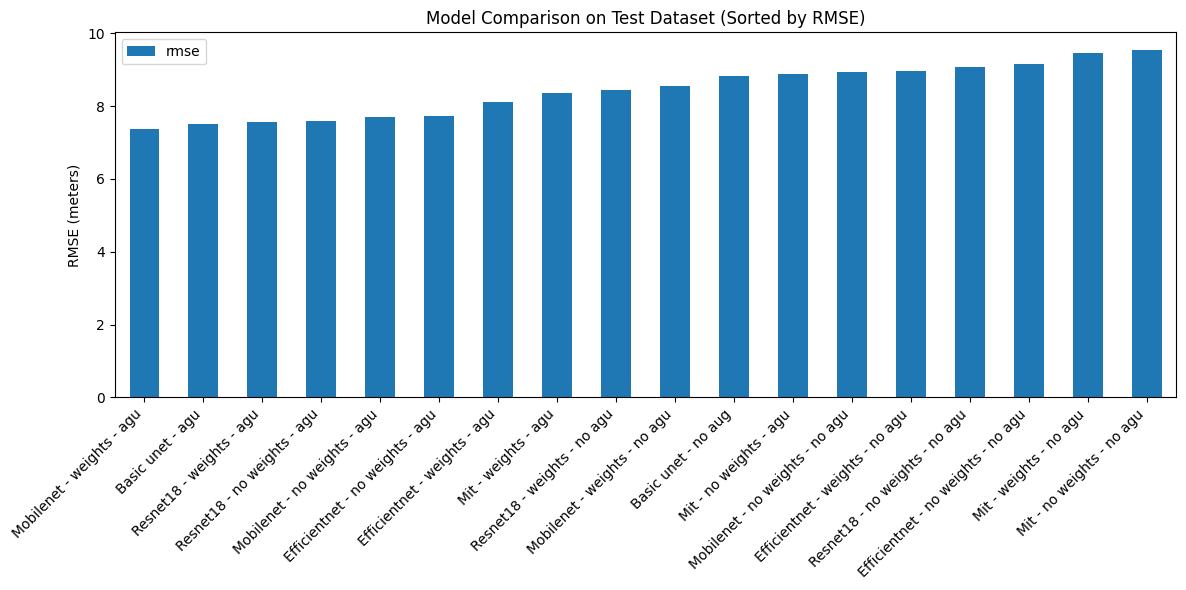

In [ ]:
df_results = pd.DataFrame(results).T
df_results_sorted = df_results.sort_values(by="rmse")
df_rmse_test = df_results_sorted[["rmse"]]
df_rmse_test.plot(kind="bar", figsize=(12,6))
plt.ylabel("RMSE (meters)")
plt.title("Model Comparison on Test Dataset (Sorted by RMSE)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

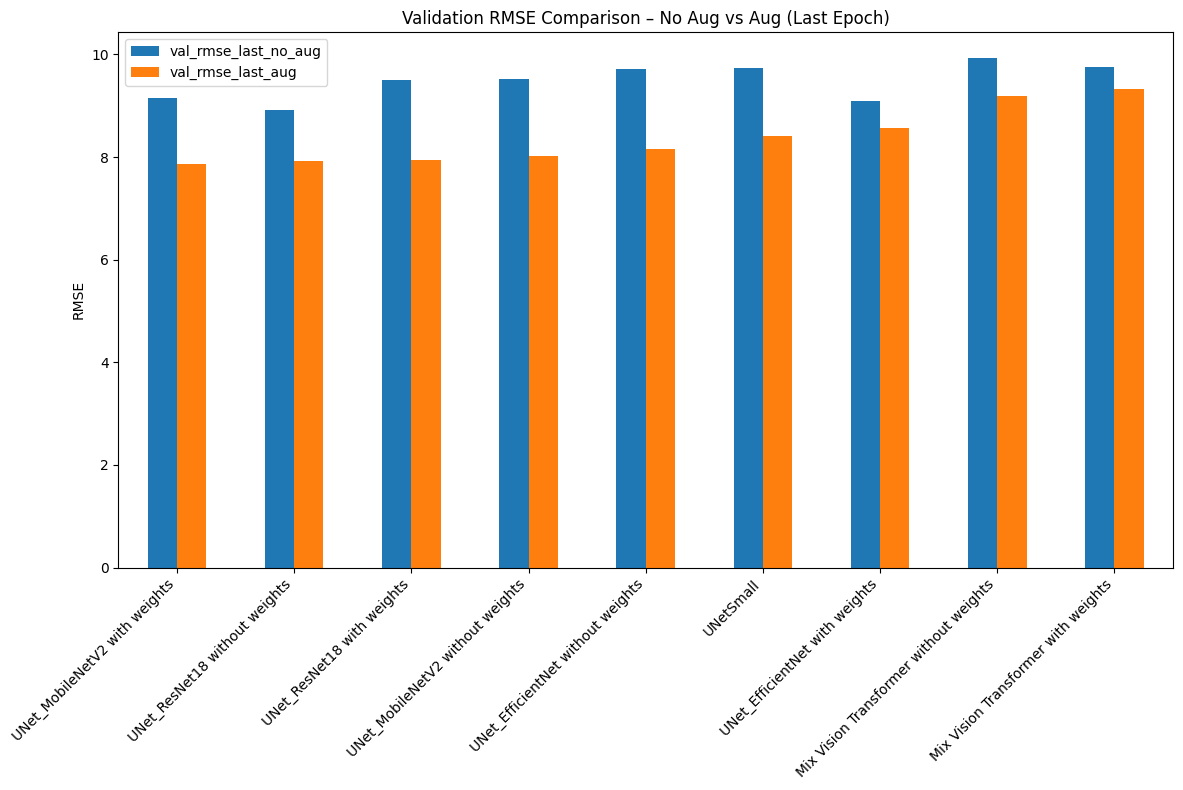

In [ ]:
# Compare training and validation too
df_no_aug = summarize_last_epoch(results_pre)
df_aug    = summarize_last_epoch(results_aug)

df_combined = df_no_aug.join(df_aug, lsuffix="_no_aug", rsuffix="_aug")

# Sort mainly by augmented validation RMSE (ascending = best first)
df_sorted = df_combined.sort_values(
    by=["val_rmse_last_aug", "val_rmse_last_no_aug"],
    ascending=[True, True]
)

df_sorted[["val_rmse_last_no_aug", "val_rmse_last_aug"]].plot(
    kind="bar",
    figsize=(12, 8)
)
plt.title("Validation RMSE Comparison – No Aug vs Aug (Last Epoch)")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Use best model for predictions

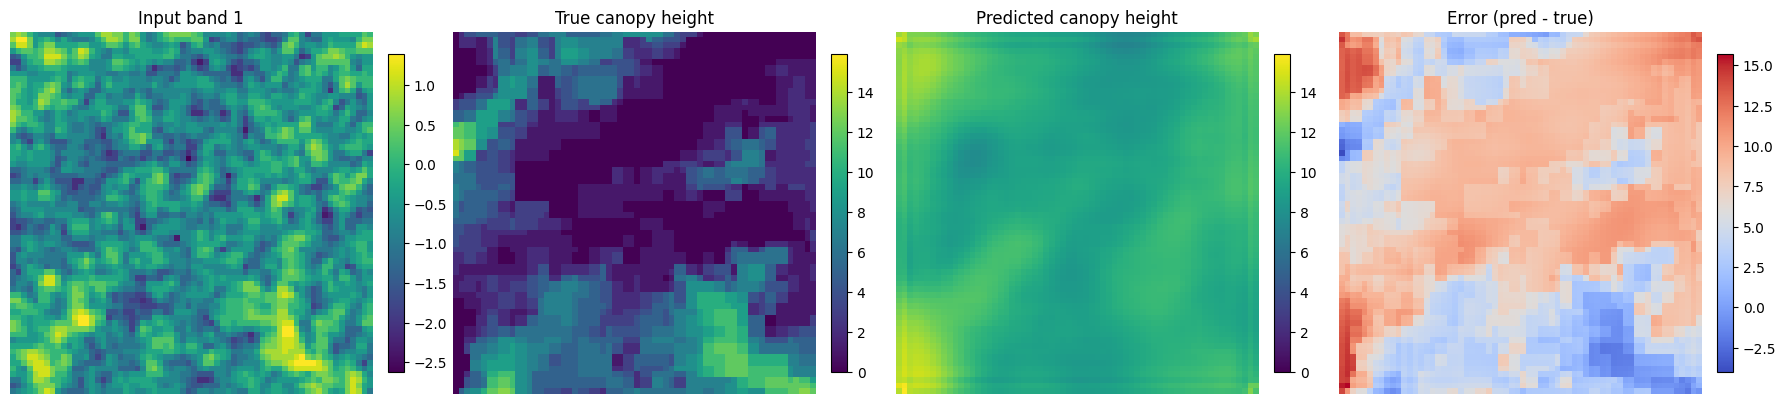

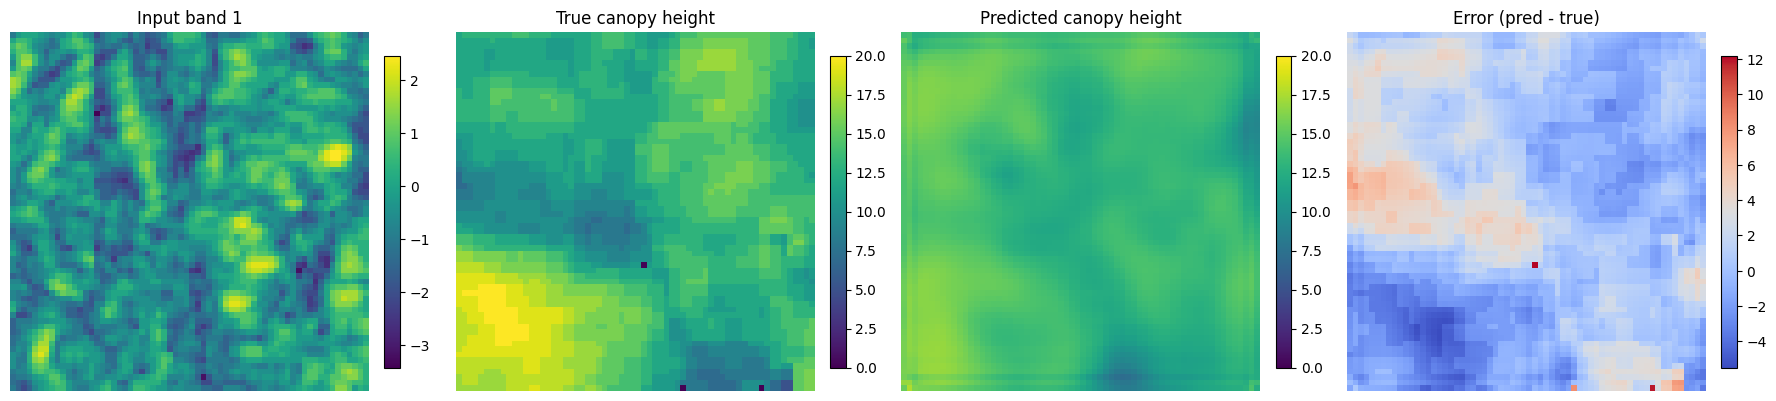

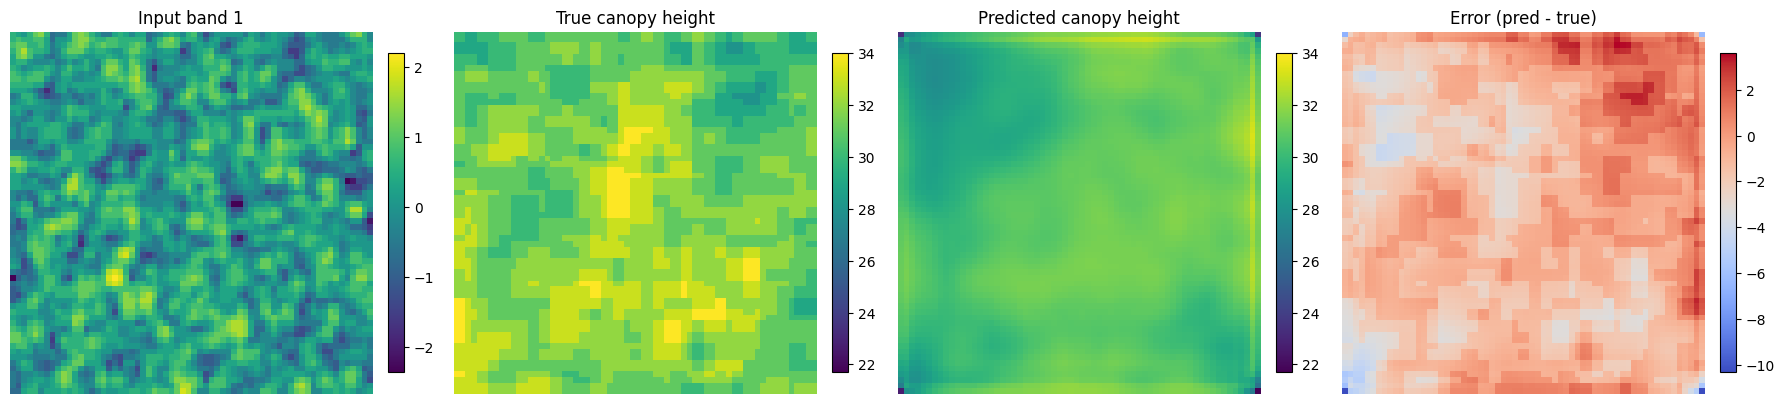

In [ ]:
y_true_test, y_pred_test = predict_test_set(
    mobilenet_weights_aug, test_dl, device
)

test_dataset = test_dl.dataset
visualize_test_tile(test_dataset, y_true_test, y_pred_test, idx=1, band_idx=0)
visualize_test_tile(test_dataset, y_true_test, y_pred_test, idx=3, band_idx=0)
visualize_test_tile(test_dataset, y_true_test, y_pred_test, idx=8, band_idx=0)
